# Imports

In [150]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import pipeline
from sklearn.metrics import f1_score
import torch
from datasets import DatasetDict
from textaugment import EDA

np.random.seed(42) 

In [163]:
DATA_PATH = "data"

def load_data(path=DATA_PATH):
    def get_path(set_type, is_args):
        return os.path.join(DATA_PATH, set_type, ("arguments" if is_args else "labels") + "-" + set_type + ".tsv")
    
    data = {}
    
    for set_type in ["test", "training", "validation"]:
        args = pd.read_csv(get_path(set_type, True), sep="\t")
        
        labels = pd.read_csv(get_path(set_type, False), sep="\t")
        labels = labels.drop("Argument ID", axis=1)
        args["Labels"] = [x for x in labels.to_numpy()]
        
        data[set_type] = args
        print(f"Set:{set_type.title()} - Size:{args.shape[0]}")
        
    classes = list(labels.columns)
    
    return data, classes

data, classes = load_data()
data["training"].head()
print("\nClasses:", classes)

Set:Test - Size:1576
Set:Training - Size:5393
Set:Validation - Size:1896

Classes: ['Self-direction: thought', 'Self-direction: action', 'Stimulation', 'Hedonism', 'Achievement', 'Power: dominance', 'Power: resources', 'Face', 'Security: personal', 'Security: societal', 'Tradition', 'Conformity: rules', 'Conformity: interpersonal', 'Humility', 'Benevolence: caring', 'Benevolence: dependability', 'Universalism: concern', 'Universalism: nature', 'Universalism: tolerance', 'Universalism: objectivity']


(5393, 5)
1259 1920
(4817, 5)
(6076, 5)


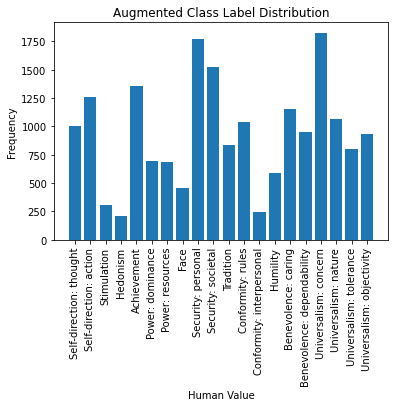

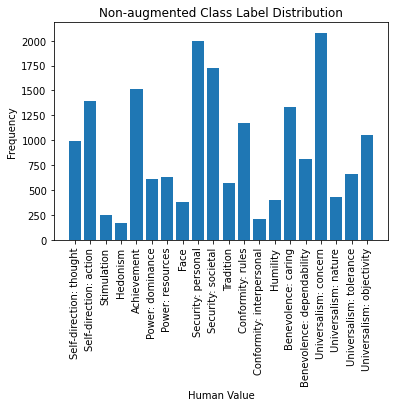

In [166]:
from itertools import chain
from collections import Counter
import random

def fix_class_imbalance(data, eda=False):
    russian_aug = np.load(os.path.join(DATA_PATH, 'train_aug', 'back_trans_ru_augm.npy'))
    german_aug = np.load(os.path.join(DATA_PATH, 'train_aug', 'back_trans_de_augm.npy'))

    data_counts = data["training"]['Labels'].sum(axis=0)
    mean_freq = np.mean(data_counts)
    min_classes = np.where(data_counts < mean_freq)[0]
    max_classes = np.where(data_counts >= mean_freq)[0]
    
    data["training_aug"] = data["training"].copy()
    print(data["training_aug"].shape)

    
    rows_to_remove = []
    rows_to_add = []
    
    for row_idx, row_labels in enumerate(data["training"]['Labels']):
        # if np.sum(np.asarray(row_labels)) == 1:
        #     class_idx = np.where(row_labels==1)
        if not np.intersect1d( np.where(row_labels==1), max_classes).any():
            premise = data["training"].iloc[row_idx]["Premise"]
            if premise.lower() != russian_aug[row_idx].lower():
                new_row = data["training"].iloc[row_idx].copy()
                new_row["Premise"] = russian_aug[row_idx]
                rows_to_add.append(new_row)
            
            if premise.lower() != german_aug[row_idx].lower() and german_aug[row_idx].lower() != new_row["Premise"].lower():
                new_row = data["training"].iloc[row_idx].copy()
                new_row["Premise"] = german_aug[row_idx]
                rows_to_add.append(new_row)
            
            if eda:
                eda = EDA()
                prem_size = len(premise)
                aug_premises = [eda.synonym_replacement(premise, int(prem_size*0.3)), 
                                eda.random_swap(premise,int(prem_size*0.2)),
                                eda.random_insertion(premise, int(prem_size*0.1)),
                                eda.random_deletion(premise, p=0.2)]
                for aug_prem in aug_premises:
                    new_row = data["training"].iloc[row_idx].copy()
                    new_row["Premise"] = aug_prem
                    rows_to_add.append(new_row)
        elif not np.intersect1d( np.where(row_labels==1), min_classes).any():
            rows_to_remove.append(row_idx)

    print(len(rows_to_add), len(rows_to_remove))
    rows_to_remove = random.sample(rows_to_remove, int(len(rows_to_remove)*0.3))
    data["training_aug"] = data["training_aug"].drop(data["training_aug"].index[rows_to_remove])
    print(data["training_aug"].shape)

    data["training_aug"] = pd.concat([pd.DataFrame(rows_to_add), data["training_aug"]]).reset_index(drop=True)


fix_class_imbalance(data, eda=True)
print(data["training_aug"].shape)

data_counts_new = data["training_aug"]['Labels'].sum(axis=0)
plt.bar(classes, data_counts_new)
plt.xlabel("Human Value")
plt.xticks(rotation='vertical')
plt.ylabel("Frequency")
plt.title("Augmented Class Label Distribution")
plt.show()

data_counts_new = data["training"]['Labels'].sum(axis=0)
plt.bar(classes, data_counts_new)
plt.xlabel("Human Value")
plt.xticks(rotation='vertical')
plt.ylabel("Frequency")
plt.title("Non-augmented Class Label Distribution")
plt.show()
    

918.5
[ 2  3  5  6  7 10 12 13 15 17 18]
(5393, 5)
(8854, 5)


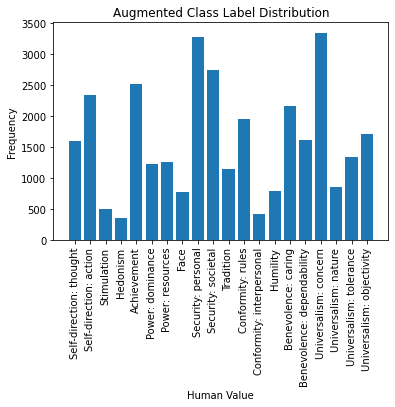

In [5]:
def add_augmented_data(data):
    russian_aug = np.load(os.path.join(DATA_PATH, 'train_aug', 'back_trans_ru_augm.npy'))
    german_aug = np.load(os.path.join(DATA_PATH, 'train_aug', 'back_trans_de_augm.npy'))

    data_counts = data["training"]['Labels'].sum(axis=0)
    mean_freq = np.mean(data_counts)
    min_classes = np.where(data_counts < mean_freq)[0]
    print(mean_freq)
    print(min_classes)

    data["training_aug"] = data["training"].copy()
    print(data["training_aug"].shape)

    rows_to_add = []

    for row_idx, row_labels in enumerate(data["training"]['Labels']):
        for flagged_classes in np.where(row_labels==1):
            if np.intersect1d(flagged_classes, min_classes).any():

                new_row = data["training"].iloc[row_idx].copy()
                new_row["Premise"] = german_aug[row_idx] if np.random.random() > 0.5 else russian_aug[row_idx]
                rows_to_add.append(new_row)

    data["training_aug"] = pd.concat([pd.DataFrame(rows_to_add), data["training_aug"]]).reset_index(drop=True)

add_augmented_data(data)
print(data["training_aug"].shape)

data_counts_new = data["training_aug"]['Labels'].sum(axis=0)
plt.bar(classes, data_counts_new)
plt.xlabel("Human Value")
plt.xticks(rotation='vertical')
plt.ylabel("Frequency")
plt.title("Augmented Class Label Distribution")
plt.show()

# Pre-processing

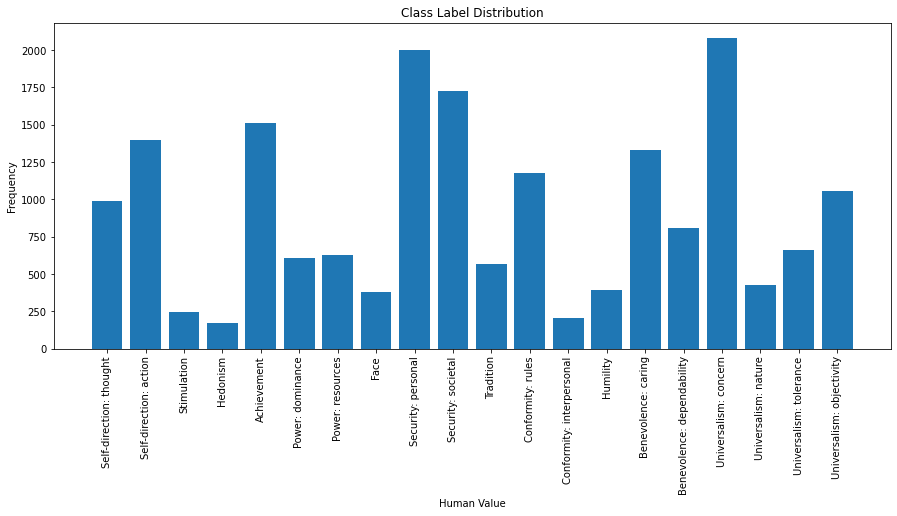

In [224]:
data_counts = data["training"]['Labels'].sum(axis=0)
plt.bar(classes, data_counts)
plt.xlabel("Human Value")
plt.xticks(rotation='vertical')
plt.ylabel("Frequency")
plt.title("Class Label Distribution")
plt.show()

# Model

In [6]:
def accuracy_thresh(y_pred, y_true, thresh=0.5, sigmoid=True):
    """Compute accuracy of predictions"""
    y_pred = torch.from_numpy(y_pred)
    y_true = torch.from_numpy(y_true)
    if sigmoid:
        y_pred = y_pred.sigmoid()

    return ((y_pred > thresh) == y_true.bool()).float().mean().item()


def f1_score_per_label(y_pred, y_true, value_classes, thresh=0.5, sigmoid=True):
    """Compute label-wise and averaged F1-scores"""
    y_pred = torch.from_numpy(y_pred)
    y_true = torch.from_numpy(y_true)
    if sigmoid:
        y_pred = y_pred.sigmoid()

    y_true = y_true.bool().numpy()
    y_pred = (y_pred > thresh).numpy()

    f1_scores = {}
    for i, v in enumerate(value_classes):
        f1_scores[v] = round(f1_score(y_true[:, i], y_pred[:, i], zero_division=0), 2)

    f1_scores['avg-f1-score'] = round(np.mean(list(f1_scores.values())), 2)

    return f1_scores


def compute_metrics(eval_pred, value_classes):
    """Custom metric calculation function for MultiLabelTrainer"""
    predictions, labels = eval_pred
    f1scores = f1_score_per_label(predictions, labels, value_classes)
    return {'accuracy_thresh': accuracy_thresh(predictions, labels), 'f1-score': f1scores,
            'macro-avg-f1score': f1scores['avg-f1-score']}

In [49]:
class MultiLabelTrainer(Trainer):
    """
        A transformers `Trainer` with custom loss computation

        Methods
        -------
        compute_loss(model, inputs, return_outputs=False):
            Overrides loss computation from Trainer class
        """
    def compute_loss(self, model, inputs, return_outputs=False):
        """Custom loss computation"""
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.BCEWithLogitsLoss()
        loss = loss_fct(logits.view(-1, self.model.config.num_labels),
                        labels.float().view(-1, self.model.config.num_labels))
        return (loss, outputs) if return_outputs else loss

In [58]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

label_values = ["Self-direction: thought", "Self-direction: action", "Stimulation", "Hedonism", "Achievement", "Power: dominance", "Power: resources", "Face", "Security: personal", "Security: societal", "Tradition", "Conformity: rules", "Conformity: interpersonal", "Humility", "Benevolence: caring", "Benevolence: dependability", "Universalism: concern", "Universalism: nature", "Universalism: tolerance", "Universalism: objectivity"]


def encode(str_input):
    return tokenizer(str_input, truncation=True)

train_data = data["training"]["Premise"]
train_data = train_data.map(encode)
for i, x in enumerate(train_data):
    x["labels"] = data["training"]["Labels"][i]

val_data = data["validation"]["Premise"]
val_data = val_data.map(encode)
for i, x in enumerate(val_data):
    x["labels"] = data["validation"]["Labels"][i]
    
test_data = data["test"]["Premise"]
test_data = test_data.map(encode)

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", 
                                                           num_labels=len(classes))
    
if torch.cuda.is_available():
    model = model.to('cuda')

training_args = TrainingArguments(
    output_dir="models",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=20,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='macro-avg-f1score',
    evaluation_strategy="steps",
)

print(val_data[0])

trainer = MultiLabelTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    tokenizer=tokenizer,
    compute_metrics=lambda x: compute_metrics(x, label_values),
)

trainer.train()
model.save_pretrained("test")


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classi

{'input_ids': [101, 2065, 4372, 6494, 24073, 2064, 3710, 2000, 2062, 4089, 5425, 2359, 12290, 1010, 2059, 2339, 5807, 1005, 1056, 2009, 2022, 3423, 1029, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}


Step,Training Loss,Validation Loss,Accuracy Thresh,F1-score,Marco-avg-f1score
500,0.415600,0.370113,0.849974,"{'Self-direction: thought': 0.1, 'Self-direction: action': 0.23, 'Stimulation': 0.0, 'Hedonism': 0.0, 'Achievement': 0.3, 'Power: dominance': 0.0, 'Power: resources': 0.0, 'Face': 0.0, 'Security: personal': 0.64, 'Security: societal': 0.59, 'Tradition': 0.01, 'Conformity: rules': 0.0, 'Conformity: interpersonal': 0.0, 'Humility': 0.0, 'Benevolence: caring': 0.0, 'Benevolence: dependability': 0.0, 'Universalism: concern': 0.59, 'Universalism: nature': 0.0, 'Universalism: tolerance': 0.0, 'Universalism: objectivity': 0.0, 'avg-f1-score': 0.12}",0.120000
1000,0.351000,0.349526,0.857173,"{'Self-direction: thought': 0.29, 'Self-direction: action': 0.32, 'Stimulation': 0.0, 'Hedonism': 0.0, 'Achievement': 0.58, 'Power: dominance': 0.0, 'Power: resources': 0.27, 'Face': 0.0, 'Security: personal': 0.72, 'Security: societal': 0.63, 'Tradition': 0.08, 'Conformity: rules': 0.19, 'Conformity: interpersonal': 0.0, 'Humility': 0.0, 'Benevolence: caring': 0.05, 'Benevolence: dependability': 0.0, 'Universalism: concern': 0.57, 'Universalism: nature': 0.1, 'Universalism: tolerance': 0.0, 'Universalism: objectivity': 0.01, 'avg-f1-score': 0.19}",0.190000


Trainer is attempting to log a value of "{'Self-direction: thought': 0.1, 'Self-direction: action': 0.23, 'Stimulation': 0.0, 'Hedonism': 0.0, 'Achievement': 0.3, 'Power: dominance': 0.0, 'Power: resources': 0.0, 'Face': 0.0, 'Security: personal': 0.64, 'Security: societal': 0.59, 'Tradition': 0.01, 'Conformity: rules': 0.0, 'Conformity: interpersonal': 0.0, 'Humility': 0.0, 'Benevolence: caring': 0.0, 'Benevolence: dependability': 0.0, 'Universalism: concern': 0.59, 'Universalism: nature': 0.0, 'Universalism: tolerance': 0.0, 'Universalism: objectivity': 0.0, 'avg-f1-score': 0.12}" of type <class 'dict'> for key "eval/f1-score" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'Self-direction: thought': 0.29, 'Self-direction: action': 0.32, 'Stimulation': 0.0, 'Hedonism': 0.0, 'Achievement': 0.58, 'Power: dominance': 0.0, 'Power: resources': 0.27, 'Face': 0.0, 'Security: personal': 0.7

In [137]:
def test(data, classes, model_name, tok_name):
    model_eval = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(classes))
    tokenizer_eval = AutoTokenizer.from_pretrained(tok_name)
    trainer_eval = MultiLabelTrainer(model_eval, tokenizer=tokenizer_eval)

    def encode(str_input):
        return tokenizer_eval(str_input, truncation=True)

    eval_data = data["Premise"].map(encode)

    pred = trainer_eval.predict(eval_data).predictions
    
    true = np.array([x for x in data["Labels"]])
    f1_scores = f1_score_per_label(pred, true, classes)
    
    return f1_scores
    
f1_scores_bert = test(data["test"], classes, "bert_paper_model", "bert-base-uncased")
f1_scores_distilbert = test(data["test"], classes, "own-distilbert-model", "distilbert-base-uncased")
f1_scores_roberta = test(data["test"], classes, "own-roberta-model", "roberta-base")

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


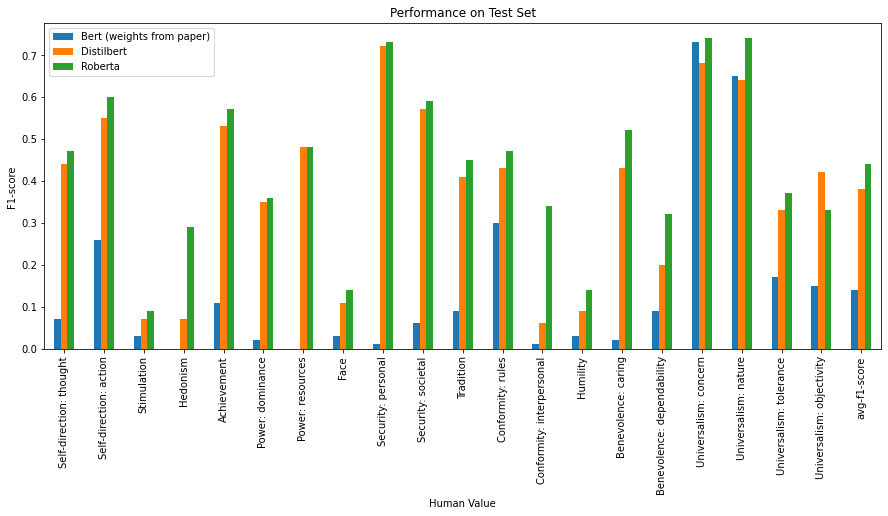

In [229]:
df = pd.DataFrame({"Human Value": f1_scores_bert.keys(),
                   "Bert (weights from paper)": f1_scores_bert.values(), 
                   "Distilbert": f1_scores_distilbert.values(),
                   "Roberta": f1_scores_roberta.values()})

df.head()
plt.rcParams["figure.figsize"] = (15,6)
df.plot(x="Human Value", y=["Bert (weights from paper)", "Distilbert", "Roberta"], kind="bar")
plt.title("Performance on Test Set")
plt.ylabel("F1-score")
plt.show()

In [228]:
# df = pd.DataFrame({"Human Value": f1_scores_bert.keys(),
#                    "Bert (weights from paper)": f1_scores_bert.values(), 
#                    "Distilbert": f1_scores_distilbert.values(),
#                    "Roberta": f1_scores_roberta.values()})

# df.head()
# plt.rcParams["figure.figsize"] = (15,6)
# df.plot(x="Human Value", y=["Bert (weights from paper)", "Distilbert", "Roberta"], kind="bar")
# plt.title("Performance on Validation Set")
# plt.ylabel("F1-score")
# plt.show()